In [31]:
import numpy as np
from astropy.io import fits
import glob 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import Column, Table, join
%matplotlib inline

In [41]:
# hd142527 HGCA EDR3 table
Table(fits.getdata('HGCA_vEDR3_withchi2.fits'))[Table(fits.getdata('HGCA_vEDR3_withchi2.fits'))['hip_id']=='HIP78092']

hip_id,gaia_source_id,gaia_ra,gaia_dec,radial_velocity,radial_velocity_error,radial_velocity_source,parallax_gaia,parallax_gaia_error,pmra_gaia,pmdec_gaia,pmra_gaia_error,pmdec_gaia_error,pmra_pmdec_gaia,pmra_hg,pmdec_hg,pmra_hg_error,pmdec_hg_error,pmra_pmdec_hg,pmra_hip,pmdec_hip,pmra_hip_error,pmdec_hip_error,pmra_pmdec_hip,epoch_ra_gaia,epoch_dec_gaia,epoch_ra_hip,epoch_dec_hip,crosscal_pmra_hip,crosscal_pmdec_hip,crosscal_pmra_hg,crosscal_pmdec_hg,nonlinear_dpmra,nonlinear_dpmdec,chisq
int32,int64,float64,float64,float32,float32,str8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32
1,2738327528519591936,0.0008719567839042787,1.0889790016455836,8.260943,0.26423287,Gaia_DR2,5.415096,0.03313692,-0.36014107,-5.052624,0.07906983,0.029551376,0.11232172,-5.8315926,-5.092949,0.05085897,0.028544432,0.37032557,-4.8750935,-1.0176214,1.3064564,0.7988536,0.3501338,2015.927490234375,2015.5340576171875,1991.5512935408415,1991.2750844407499,-0.028456224,0.46625093,-0.0013415869,-0.0037278787,6.5350346e-06,5.610078e-06,3515.1296


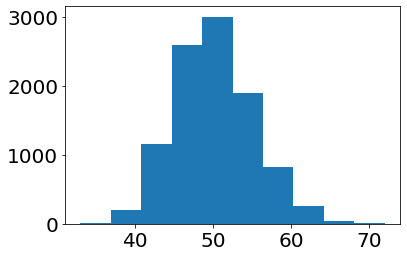

In [2]:
# utility function for visualizing a lognormal distribution as interpreted by orvara for setting starting parameters
def plot_lognormal(mu, sig): 
    plt.hist(mu * np.exp(np.random.randn(10000)*sig)) 
    plt.show() 
    return None

plot_lognormal(50, 0.1)

# utility function for plots of angular data
def angular_average(angles):
    # angles in degrees
    x = np.sum(np.cos(angles * np.pi/180))
    y = np.sum(np.sin(angles * np.pi/180))
    average_angle = np.arctan2(y, x) * 180/np.pi
    return average_angle

def center_angular_data(data):
    avg = angular_average(data)
    # wrap the data in the interval +- 180 degrees around the average. This should center multimodal angular distributions
    gt = data > avg + 180
    lt = data < avg - 180
    data[gt] -= 360
    data[lt] += 360
    return data

### Secondary Mass

['mpri', 'msec0', 'sau0', 'esino0', 'ecoso0', 'inc0', 'asc0', 'lam0', 'jitter', 'lnp', 'plx_ML', 'pmra_ML', 'pmdec_ML', 'chisq_sep', 'chisq_PA', 'chisq_H', 'chisq_HG', 'chisq_G', 'RV_ZP_0_ML']
plx_ML = 0.006278300118740639
pmra_ML = -0.017321715079692712
pmdec_ML = -0.015466087777838476
chisq_sep = 2862.1452334514647
chisq_PA = 21667.5743749211
chisq_H = 0.7486143519022874
chisq_HG = 767.3854112534443
chisq_G = 1287.9585814857994
best step parameters ###
mpri = 743.2025852295751
msec0 = 963.7180892399022
sau0 = 23293.27620669247
esino0 = 0.7885261139365167
ecoso0 = -0.2694319240170524
inc0 = 2.952892799830622
asc0 = 8.411797060769057
lam0 = 1.6768475503587514
jitter = 1.5146998401060878
RV_ZP_0_ML = 0.0
###
853277.684\pmoffs{145601.208}{579303.698}
853277.684\pmoffs{193709.924}{853275.077}


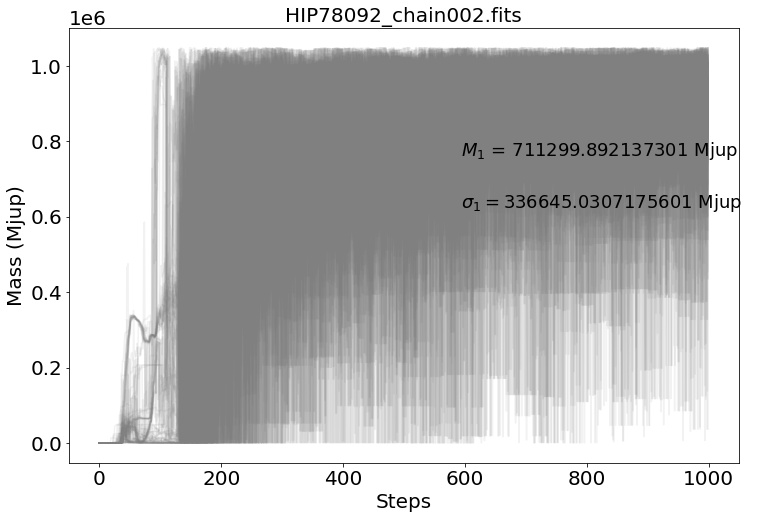

In [26]:
import os

def print_statistics(data, interval=15.9):
    median = np.percentile(data, 50)
    #print('median, mean, 68 p interval:', median, np.mean(data), np.percentile(data, 68))
    #print('1 sigma interval about median:', median -  np.percentile(data, interval),  np.percentile(data, 100-interval) - median)
    print(f'{np.percentile(data, 50):.3f}' + '\pmoffs{' + f'{np.percentile(data, 100-interval) - median:.3f}' + '}{' + f'{median - np.percentile(data, interval):.3f}' + '}')
    # 15.9% and 84.1% are the 1 and 2 sigma limits. So median - 15.9% and 84.1% - median give the upper and lower bounds


# Gl 758
path = 'HIP78092_chain002.fits'

# HD 13724
# path = '/home/gmbrandt/Documents/misc_codes/orbit_fits/HD13724/chains/HIP10278_neworvara_config_long_multiple_jitters_noepochast.fits'
# path = '/home/gmbrandt/Documents/misc_codes/orbit_fits/HD13724/chains/HIP10278_neworvara_config_long_multiple_jitters_epochast.fits'
"""
nsteps = 50 * tt['lnp'].shape[1]
burn = 250  # number of burn in steps to discard
rv_jitter = np.mean(tt['jitter'][i, burn:])
rv_jitter_err = np.std(tt['jitter'][i, burn:])
companion_jup_mass = np.mean(tt['msec0'][i, burn:]*1989/1.898)
companion_mass_stderr = np.std(tt['msec0'][i, burn:]*1989/1.898)
separation_AU = np.mean(tt['sau0'][i, burn:])
separation_stderr = np.std(tt['sau0'][i, burn:])
eccentricity = np.mean(tt['esino0'][i, burn:]**2 + tt['ecoso0'][i, burn:]**2)
eccentricity_stderr = np.std(tt['esino0'][i, burn:]**2 + tt['ecoso0'][i, burn:]**2)
inclination_deg = np.mean(tt['inc0'][i, burn:]*180/np.pi)
inclination_err = np.std(tt['inc0'][i, burn:]*180/np.pi)
"""

source = os.path.basename(path)
tt = Table(fits.open(path)[1].data)
nsteps = 50 * tt['lnp'].shape[1]
nwalkers = tt['msec0'].shape[0]
print(tt.colnames)

burn= int(0.95 * nsteps)

if burn >= nsteps:
    burn = int(nsteps/2)

####
#checking chisquareds
chisqchain = tt['lnp']
logl = tt['lnp']
#print(logl[logl == np.max(logl)])
chisquareds = tt[['plx_ML', 'pmra_ML', 'pmdec_ML', 'chisq_sep', 'chisq_PA', 'chisq_H', 'chisq_HG', 'chisq_G']]
maxl_indices = np.amax(logl) == logl
for i in chisquareds.colnames:
    print(i, '=', chisquareds[maxl_indices][i][0])

print('best step parameters ###')
params = tt.colnames
params = [c for c in params if c not in chisquareds.colnames + ['lnp']]
for i in params:
    print(i, '=', tt[maxl_indices][i][0])
print('###')
####

plt.figure(figsize=(12,8))
nplanets = 1
if 'msec1' in tt.colnames:
    nplanets = 2
for j, color in zip(range(nplanets), ['grey', 'blue']):
    for i in range(nwalkers):
        plt.plot(tt['msec' + str(j)][i, :]*1989/1.898,c=color,alpha=0.1)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel('Mass (Mjup)',fontsize=20)
    walkers = tt['msec' + str(j)].flatten()
    #primary_mass = tt[:, burn:, 1].flatten()
    #walkers = walkers[np.logical_and(primary_mass < 1.5, primary_mass>0.5)]
    
    print_statistics(walkers*1989/1.898)
    print_statistics(walkers*1989/1.898, interval=0.3)
    masses = walkers*1989/1.898
    err = np.std(walkers*1989/1.898)
    plt.annotate(fr'$M_{1+j}$ = '+str(np.mean(masses))+' Mjup',xy=(0.6, 0.7 + j/5), xycoords='figure fraction', fontsize=18)
    plt.annotate(fr'$\sigma_{1+j} = $'+str(err)+' Mjup',xy=(0.6, 0.6 + j/5), xycoords='figure fraction',fontsize=18)
#     plt.ylim((np.percentile(masses, 5) - 3*err, np.percentile(masses, 95) + 3*err))


0.945\pmoffs{0.072}{0.064}
0.945\pmoffs{0.227}{0.163}


Text(0.6, 0.6, '$\\sigma_1 = $0.06921532699643583 Mjup')

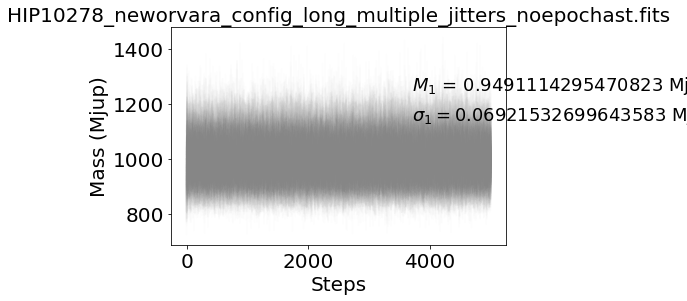

In [7]:

for i in range(nwalkers):
    plt.plot(tt['mpri'][i, :]*1989/1.898,c=color,alpha=0.01)
plt.title(source,fontsize=20)
plt.xlabel('Steps',fontsize=20)
plt.ylabel('Mass (Mjup)',fontsize=20)
walkers = tt['mpri'].flatten()
#primary_mass = tt[:, burn:, 1].flatten()
#walkers = walkers[np.logical_and(primary_mass < 1.5, primary_mass>0.5)]

print_statistics(walkers)
print_statistics(walkers, interval=0.3)
masses = walkers
err = np.std(walkers)
plt.annotate(fr'$M_{1+j}$ = '+str(np.mean(masses))+' Mjup',xy=(0.6, 0.7 + j/5), xycoords='figure fraction', fontsize=18)
plt.annotate(fr'$\sigma_{1+j} = $'+str(err)+' Mjup',xy=(0.6, 0.6 + j/5), xycoords='figure fraction',fontsize=18)
#plt.ylim((np.percentile(masses, 5) - 3*err, np.percentile(masses, 95) + 3*err))

### Separation

In [17]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 3 + 7*j
    for i in range(tt.shape[0]):
        plt.plot(tt[i,:,dataidx],c=color,alpha=0.003)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel('Separation (AU)',fontsize=20)
    print_statistics(tt[:,burn:,dataidx].flatten())
    print_statistics(tt[:,burn:,dataidx].flatten(), interval=0.3)
    plt.annotate(fr'$a_{1+j} = $'+str(np.mean(tt[:,burn:,dataidx]))+' AU',xy=(0.6, 0.7 +.05*j), xycoords='figure fraction', fontsize=18)
    plt.annotate(fr'$\sigma_{1+j}$ = '+str(np.std(tt[:,burn:,dataidx]))+' AU',xy=(0.6, 0.6+.05*j), xycoords='figure fraction', fontsize=18)
    #plt.ylim(0, 20)
    
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 3 + 7*j
    plt.hist(tt[i,:,dataidx].flatten(), bins=100, color=color, alpha=0.7)
    plt.title(source,fontsize=20)
    plt.xlabel('SMA (AU)',fontsize=20)
plt.show()

AttributeError: 'Table' object has no attribute 'shape'

<Figure size 864x576 with 0 Axes>

### Eccentricity

In [18]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 4 + 7*j
    for i in range(tt.shape[0]):
        plt.plot(tt[i,:,dataidx]**2 + tt[i,:,dataidx+1]**2,c=color,alpha=0.002)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel('Eccentricity',fontsize=20)
    mean_ecc = np.mean(tt[:,burn:,dataidx]**2 + tt[:,burn:,dataidx+1]**2)
    sigma_ecc = np.std(tt[:,burn:,dataidx]**2 + tt[:,burn:,dataidx+1]**2)
    plt.annotate(fr'$e = {mean_ecc:.4f}, \sigma={sigma_ecc:.4f}$',xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    print('e sinomega = ', np.mean(tt[:,burn:,dataidx]), 'e cosomega = ', np.mean(tt[:,burn:,dataidx+1]))

    
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = (4 + 7*j, 5 + 7*j)
    data = tt[:,:,dataidx[0]]**2 + tt[:,:, dataidx[1]]**2
    counts, bins = np.histogram(data[:, burn:].flatten(), bins=100)
    plt.hist(bins[:-1], bins, weights=counts/np.max(counts), alpha=0.8, color=color)
    print_statistics(data[:, burn:].flatten())
    print_statistics(data[:, burn:].flatten(), interval=0.3)
    plt.title(source,fontsize=20)
    plt.xlabel(r'eccentricity',fontsize=20)
plt.show()

AttributeError: 'Table' object has no attribute 'shape'

<Figure size 864x576 with 0 Axes>

### Inclination

77.776\pmoffs{31.946}{28.214}
77.776\pmoffs{48.896}{37.142}
86.290\pmoffs{2.096}{1.999}
86.290\pmoffs{3.442}{3.269}


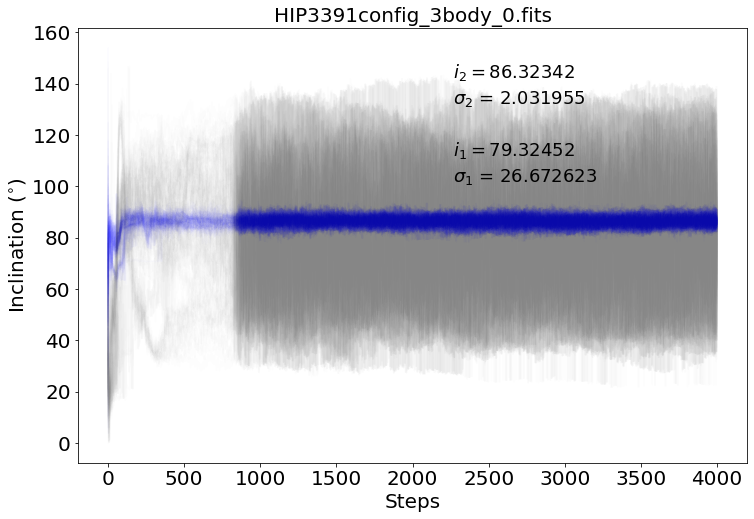

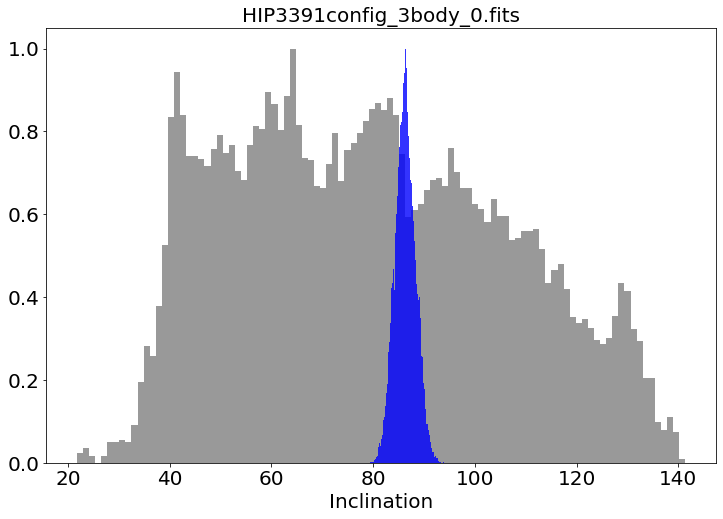

In [33]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 6 + 7*j
    for i in range(tt.shape[0]):
        plt.plot(tt[i,:,dataidx]*180/np.pi,c=color,alpha=0.01)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel('Inclination ($^{\circ}$)',fontsize=20)
    plt.annotate(fr'$i_{j+1} = $'+str(np.mean(tt[:,burn:,dataidx]*180/np.pi)),xy=(0.6, 0.7+0.15*j), xycoords='figure fraction', fontsize=18)
    plt.annotate(fr'$\sigma_{j+1}$ = '+str(np.std(tt[:,burn:,dataidx]*180/np.pi)),xy=(0.6, 0.65+0.15*j), xycoords='figure fraction', fontsize=18)
    
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 6 + 7*j
    data = center_angular_data(tt[:,:,dataidx]*180/np.pi) % 360
    counts, bins = np.histogram(data[:, burn:].flatten(), bins=100)
    plt.hist(bins[:-1], bins, weights=counts/np.max(counts), alpha=0.8, color=color)
    print_statistics(data[:, burn:].flatten())
    print_statistics(data[:, burn:].flatten(), interval=5)
    plt.title(source,fontsize=20)
    plt.xlabel(r'Inclination',fontsize=20)
plt.show()

### RV Jitter

2.819\pmoffs{0.169}{0.154}
2.942\pmoffs{0.728}{1.049}
2.391\pmoffs{0.176}{0.165}


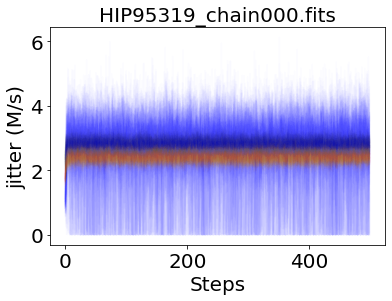

In [39]:
jitter_labels = [i for i in tt.colnames if 'jitter' in i]

for j, color in zip(jitter_labels, ['grey', 'blue', 'orange', 'red', 'teal']):
    for i in range(nwalkers):
        plt.plot(10**(tt[j][i, :]/2),c=color,alpha=0.01)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel('jitter (M/s)',fontsize=20)
    walkers = tt[j].flatten()
    #primary_mass = tt[:, burn:, 1].flatten()
    #walkers = walkers[np.logical_and(primary_mass < 1.5, primary_mass>0.5)]
    
    print_statistics(10**(walkers/2))
    #plt.annotate(fr'$M_{1+j}$ = '+str(np.mean((10**(walkers)/2)))+' Mjup',xy=(0.6, 0.7 + j/5), xycoords='figure fraction', fontsize=18)
    #plt.annotate(fr'$\sigma_{1+j} = $'+str(err)+' Mjup',xy=(0.6, 0.6 + j/5), xycoords='figure fraction',fontsize=18)



###  PA of the ascending Node

178.407 \pm 203.724
43.788 \pm 1.485
79.713\pmoffs{116.518}{127.559}
43.788\pmoffs{1.546}{1.436}


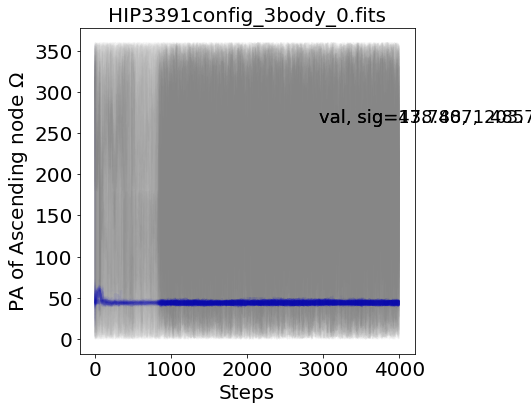

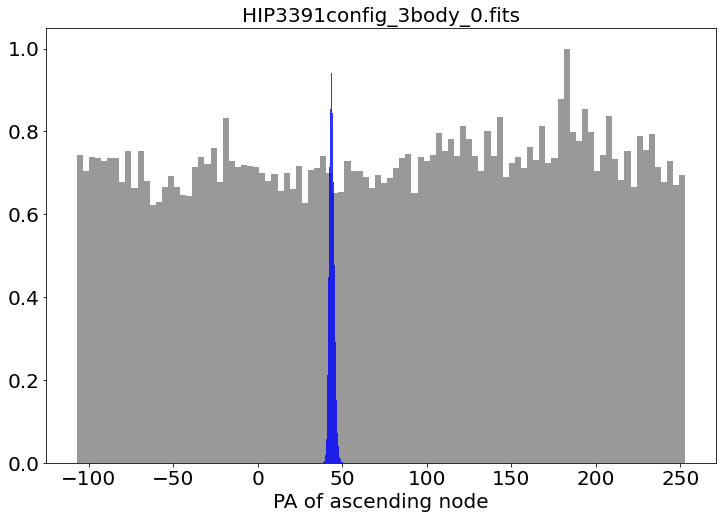

In [34]:
plt.figure(figsize=(6, 6))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 7 + 7*j
    for i in range(tt.shape[0]):
        plt.plot(tt[i,:,dataidx]*180/np.pi % 360,c=color,alpha=0.01)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel(r'PA of Ascending node $\Omega$',fontsize=20)
    plt.annotate(s=f'val, sig={np.median(tt[:,burn:,dataidx]*180/np.pi):.3f}, {np.std(tt[:,burn:,dataidx]*180/np.pi):.3f}',xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    print(f'{np.median(tt[:,burn:,dataidx]*180/np.pi):.3f} \pm {np.std(tt[:,burn:,dataidx]*180/np.pi):.3f}')
    
    
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 7 + 7*j
    #
    pa_data = center_angular_data(tt[:,:,dataidx]*180/np.pi)
    counts, bins = np.histogram(pa_data[:, burn:].flatten(), bins=100)
    plt.hist(bins[:-1], bins, weights=counts/np.max(counts), alpha=0.8, color=color)
    
    plt.title(source,fontsize=20)
    plt.xlabel(r'PA of ascending node',fontsize=20)
    print_statistics(pa_data[:, burn:].flatten())
plt.show()

###  Mean longitude at the reference epoch

203.689 \pm 0.878
-109.914 \pm 6.751


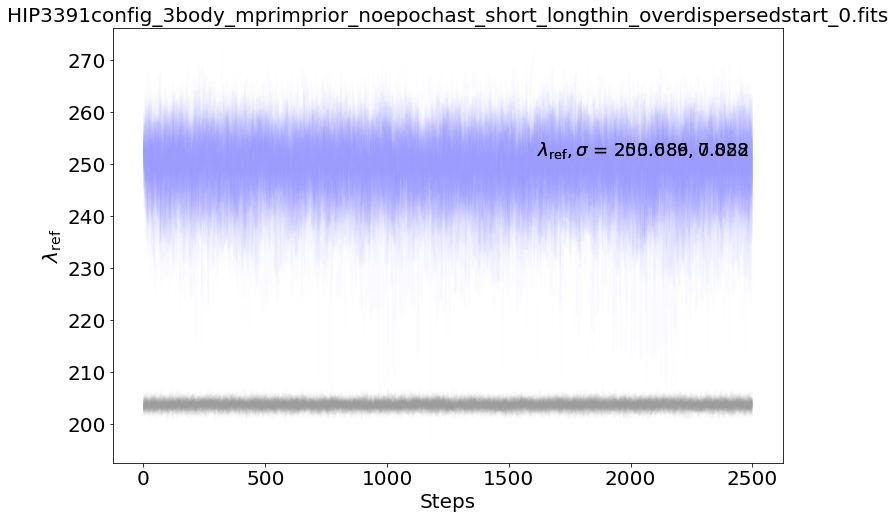

In [46]:
#Mean longitude at the reference epoch
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 8 + 7*j
    for i in range(tt.shape[0]):
        plt.plot((tt[i,:,dataidx]*180/np.pi) % 360,c=color,alpha=0.004)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel(r'$\lambda_{\rm ref}$',fontsize=20)
    plt.annotate(s=r'$\lambda_{\rm ref}, \sigma$ = ' + f'${np.median((tt[:, burn:3*burn,dataidx]*180/np.pi) % 360):.3f}, {np.std((tt[:, burn:3*burn,dataidx]*180/np.pi) % 360 - 360):.3f}$',
                xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    print(f'{np.median(tt[:,burn:,dataidx]*180/np.pi):.3f} \pm {np.std((tt[i, burn:,dataidx]*180/np.pi) % 360):.3f}')

### sqrt(ecc) cos omega and sin(omega)

-0.699 \pm 0.011
-0.247 \pm 0.225
0.641 \pm 0.012
-0.564 \pm 0.060


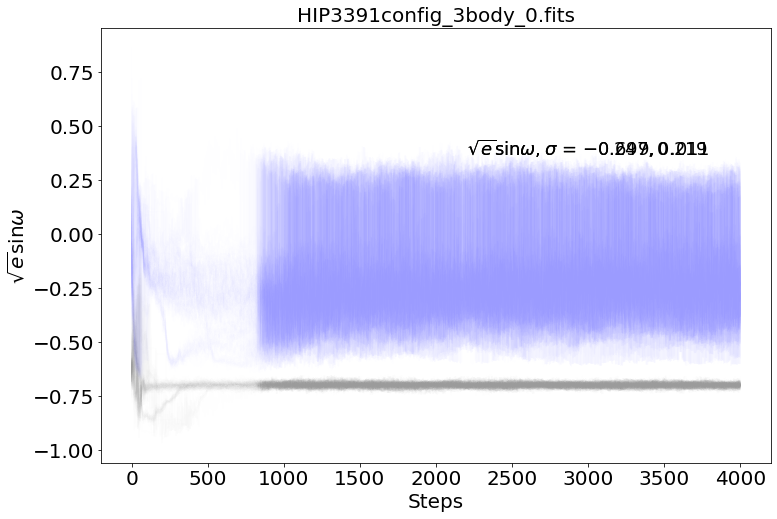

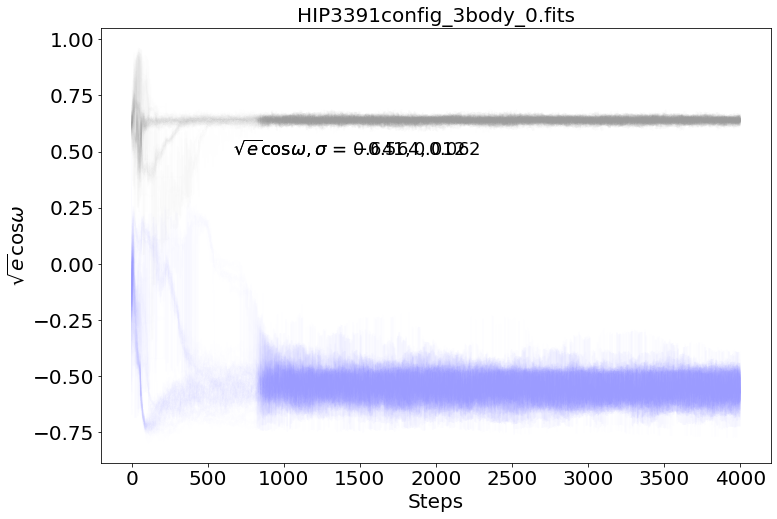

In [35]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 4 + 7*j
    for i in range(tt.shape[0]):
        plt.plot((tt[i,:,dataidx]), c=color,alpha=0.004)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel(r'$\sqrt{e} \sin \omega$',fontsize=20)
    plt.annotate(s=r'$\sqrt{e} \sin \omega, \sigma$ = ' + f'${np.median((tt[:, burn:3*burn,dataidx])):.3f}, {np.std((tt[:, burn:3*burn,dataidx])):.3f}$',
                xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    print(f'{np.median(tt[:,burn:,dataidx]):.3f} \pm {np.std((tt[i, burn:,dataidx])):.3f}')

plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):

    dataidx = 5 + 7*j
    for i in range(tt.shape[0]):
        plt.plot((tt[i,:,dataidx]), c=color,alpha=0.004)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel(r'$\sqrt{e} \cos \omega$',fontsize=20)
    plt.annotate(s=r'$\sqrt{e} \cos \omega, \sigma$ = ' + f'${np.median((tt[:, burn:3*burn,dataidx])):.3f}, {np.std((tt[:, burn:3*burn,dataidx])):.3f}$',
                xy=(0.3, 0.7), xycoords='figure fraction', fontsize=18)
    print(f'{np.median(tt[:,burn:,dataidx]):.3f} \pm {np.std((tt[i, burn:,dataidx])):.3f}')

-156.355\pmoffs{0.891}{0.891}
-108.190\pmoffs{6.359}{6.016}


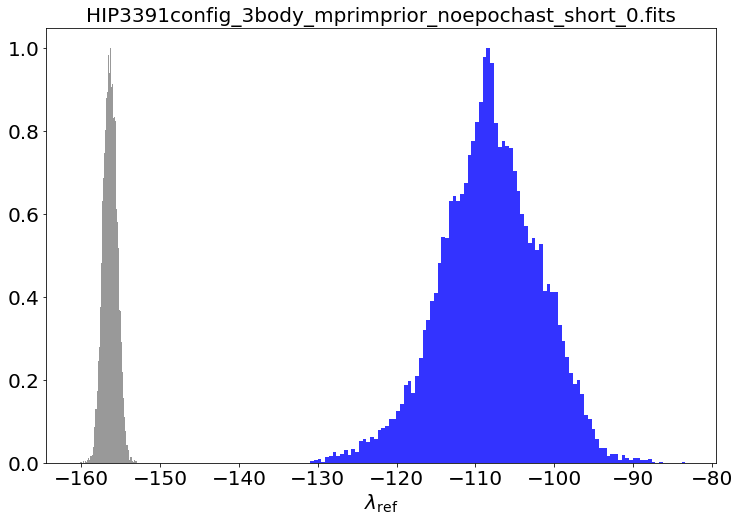

In [9]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    dataidx = 8 + 7*j
    lam_ref_data = center_angular_data(tt[:,:,dataidx]*180/np.pi)
    counts, bins = np.histogram(lam_ref_data[:, burn:].flatten(), bins=100)
    plt.hist(bins[:-1], bins, weights=counts/np.max(counts), alpha=0.8, color=color)
    print_statistics(lam_ref_data[:, burn:].flatten())
    plt.title(source,fontsize=20)
    plt.xlabel(r'$\lambda_{\rm ref}$',fontsize=20)
plt.show()

### argument of periastron

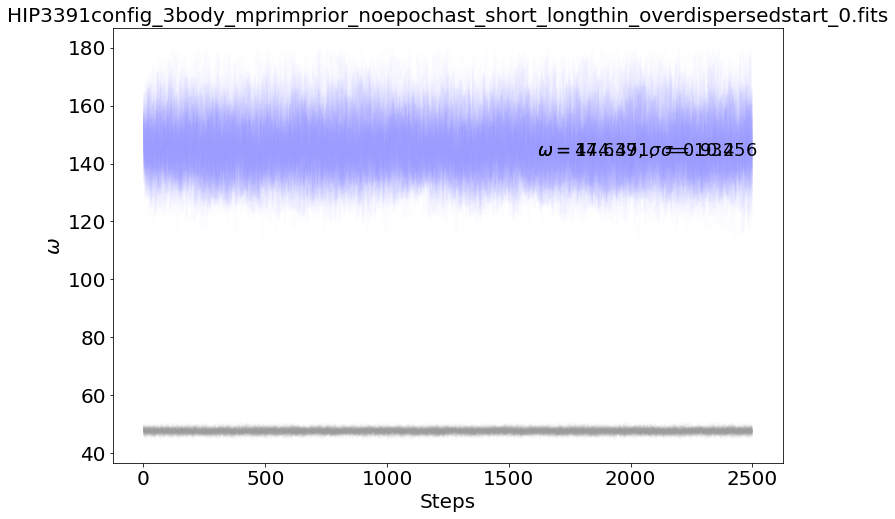

In [40]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    di = 7*j
    ecc = tt[:,:,4+di]**2 + tt[:,:,5+di]**2
    omega_data = np.arccos(tt[:,:,5+di] / np.sqrt(ecc)) *180/np.pi
    for i in range(tt.shape[0]):
        plt.plot(omega_data[i], c=color,alpha=0.005)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel(r'$\omega$',fontsize=20)
    plt.annotate(s=fr'$\omega=${np.median(omega_data[:, burn:3*burn]):.3f}, $\sigma=${np.std(omega_data[:, burn:3*burn]):.3f}', 
             xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    #print(f'{np.median(omega_data[i, burn:]):.3f} \pm {np.std(omega_data[i, burn:]):.3f}')

47.637\pmoffs{0.944}{0.917}
144.491\pmoffs{11.245}{9.566}


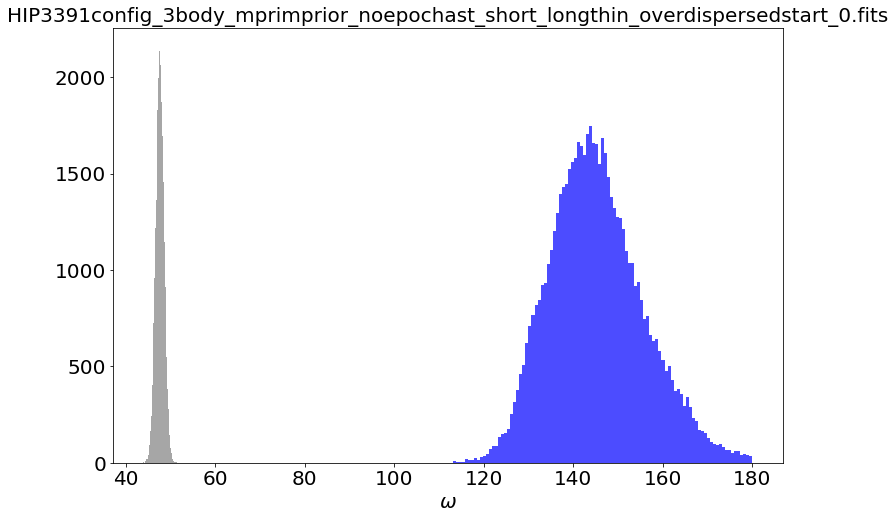

In [47]:
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    di = 7*j
    ecc = tt[:,:,4+di]**2 + tt[:,:,5+di]**2
    omega_data = center_angular_data(np.arccos(tt[:,:,5+di] / np.sqrt(ecc)) *180/np.pi)
    plt.hist(omega_data[:, burn:].flatten(), bins=100, color=color, alpha=0.7)
    print_statistics(omega_data[:, burn:].flatten())
    plt.title(source,fontsize=20)
    plt.xlabel(r'$\omega$',fontsize=20)
plt.show()

### Time of periastron

2264.4138844448416
2548122.1712934785


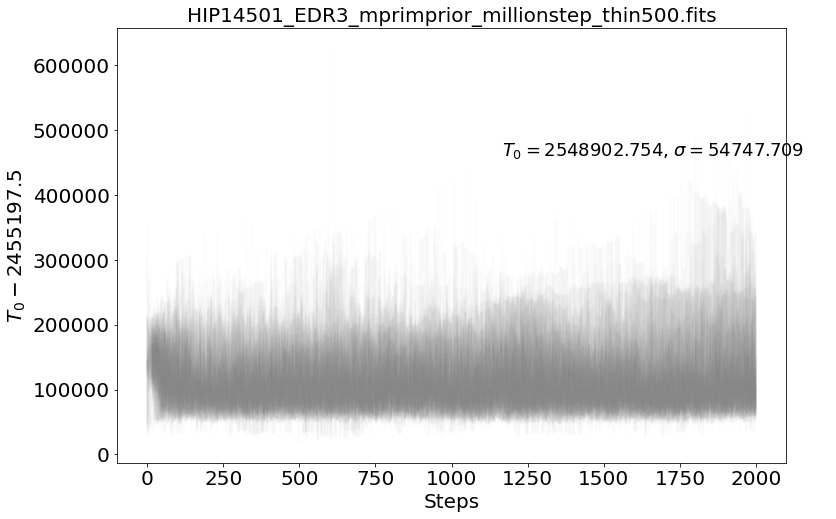

In [17]:
# time of periastron
from astropy.time import Time
plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    di= 7*j
    ecc = tt[:,:,4+di]**2 + tt[:,:,5+di]**2
    omega_data = np.arccos(tt[:,:,5+di] / np.sqrt(ecc)) *180/np.pi
    period_data = 365.25*np.sqrt(tt[:, :, 3+di]**3/(tt[:, :, 1]*1. + tt[:, :, 2+di]*1.)).astype(float)
    t0_data = 2455197.50 - period_data*((tt[:, :,8+di]*180./np.pi  % 360 - 360) - omega_data)/360. #reference epoch 2455197.5
    for i in range(tt.shape[0]):
        plt.plot(t0_data[i] - 2455197.50 , c=color, alpha=0.01)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20) 
    plt.ylabel(r'$T_0 - 2455197.5$',fontsize=20)
    plt.annotate(s=fr'$T_0=${np.median(t0_data[:, burn:]):.3f}, $\sigma=${np.std(t0_data[:, burn:]):.3f}', 
                 xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    print(Time(np.median(t0_data[i, burn:]), format='jd').jyear)
    print(np.median(t0_data[i, burn:]))

2455495.711\pmoffs{2.695}{2.616}
2499649.324\pmoffs{11538.763}{7638.472}


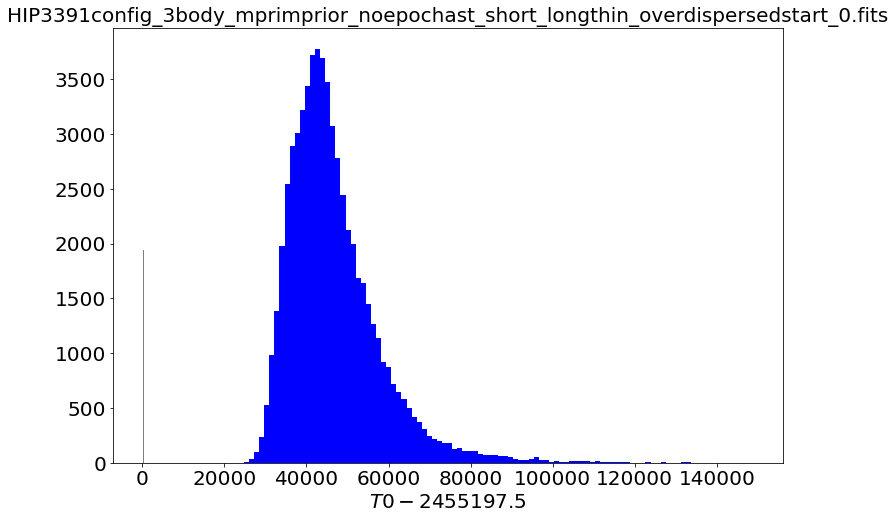

526.391\pmoffs{0.012}{0.012}
1.441\pmoffs{0.000}{0.000}
63033.271\pmoffs{15858.675}{11108.798}
172.576\pmoffs{43.419}{30.414}


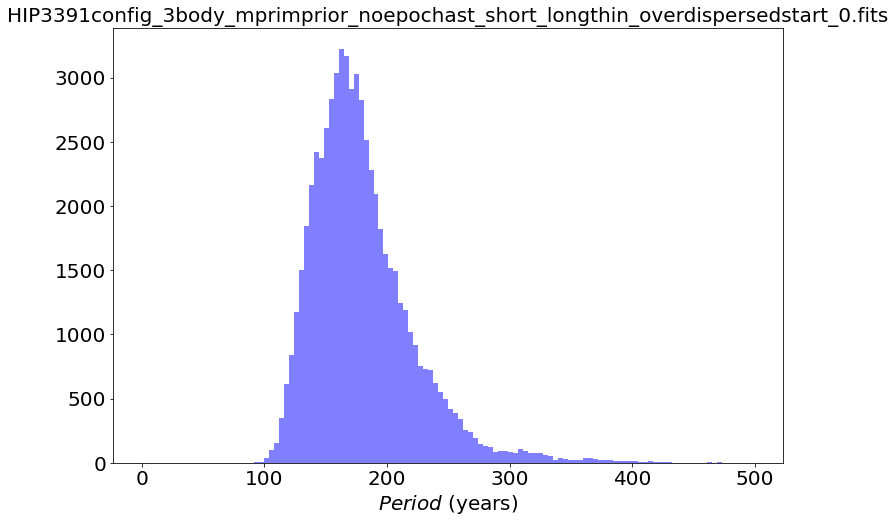

In [39]:
plt.figure(figsize=(12,8))

for j, color in zip(range(nplanets), ['grey', 'blue']):
    di = 7*j
    ecc = tt[:,:,4+di]**2 + tt[:,:,5+di]**2
    omega_data = np.arccos(tt[:,:,5+di] / np.sqrt(ecc)) *180/np.pi
    period_data = 365.25*np.sqrt(tt[:, :, 3+di]**3/(tt[:, :, 1]*1. + tt[:, :, 2+di]*1.)).astype(float)
    t0_data = 2455197.50 - period_data*((tt[:, :,8+di]*180./np.pi  % 360 - 360) - omega_data)/360. #reference epoch 2455197.5
    plt.hist(t0_data[:, burn:].flatten() - 2455197.50, bins=100, color=color)
    print_statistics(t0_data[:, burn:].flatten())
    plt.title(source,fontsize=20)
    plt.xlabel(r'$T0 - 2455197.5$',fontsize=20)
plt.show()

plt.figure(figsize=(12,8))
for j, color in zip(range(nplanets), ['grey', 'blue']):
    di = 7*j
    ecc = tt[:,:,4+di]**2 + tt[:,:,5+di]**2
    omega_data = np.arccos(tt[:,:,5+di] / np.sqrt(ecc)) *180/np.pi
    period_data = 365.25*np.sqrt(tt[:, :, 3+di]**3/(tt[:, :, 1]*1. + tt[:, :, 2+di]*1.)).astype(float)
    plt.hist(period_data[:, burn:].flatten()/365.25, bins=100, color=color, alpha=0.5)
    print_statistics(period_data[:, burn:].flatten())
    print_statistics((period_data[:, burn:]/365.25).flatten())
    plt.title(source,fontsize=20)
    plt.xlabel(r'$Period$ (years)',fontsize=20)
plt.show()

### Other best fit params, parallax etc

[-802.11395]
4 RV instruments with 4 offsets
best fit parallax (as)  =  0.023826135
pm_ra_barycenter (as/yr)  =  0.05048634
pm_dec_barycenter (as/yr)  =  -0.1132306
chisq_sep  =  1.6089892
chisq_PA  =  2.8598905
chisq_hip  =  1.0424194
chisq_hg  =  0.1627037
chisq_gaia  =  0.10741838
best fit parallax (mas) 0
23.8259453 \pm 0.0067498
pm_ra_barycenter (mas/yr) 1
50.5001210 \pm 0.1024353
pm_dec_barycenter (mas/yr) 2
-113.2215038 \pm 0.0960640
chisq_sep 3
2.0751159 \pm 1.3373795
chisq_PA 4
3.1982572 \pm 1.3093443
chisq_hip 5
1.0676768 \pm 0.2669478
chisq_hg 6
0.7108382 \pm 1.2489083
chisq_gaia 7
0.7306963 \pm 1.4752072
RVoff1 -4
45.6566467 \pm 25.1459675
RVoff2 -3
-37.4873047 \pm 25.5515518
RVoff3 -2
-35.3163986 \pm 24.4556847
RVoff4 -1
19.5213165 \pm 25.2641888


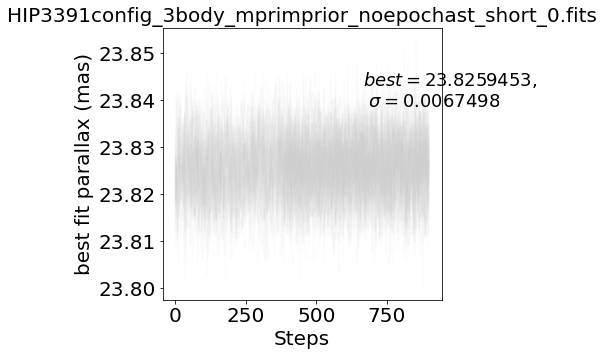

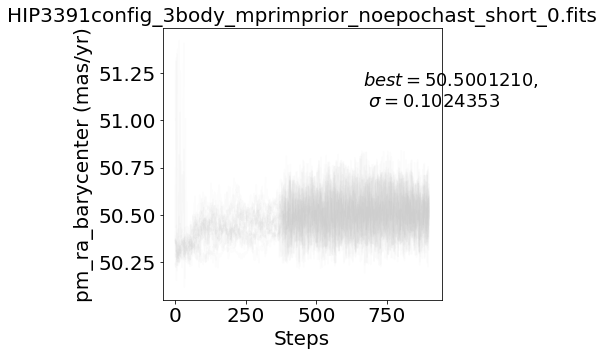

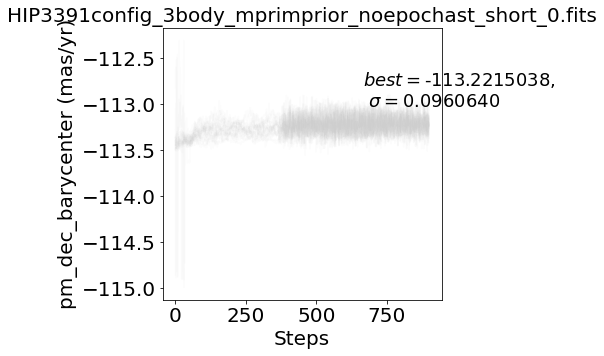

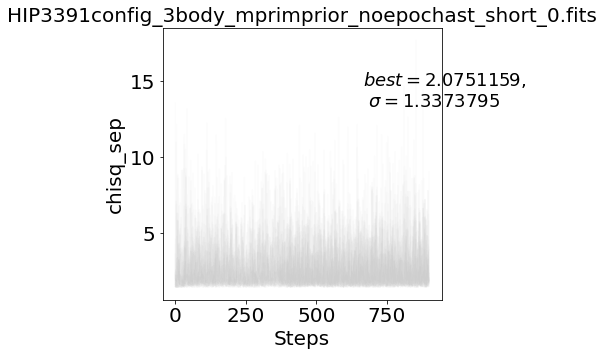

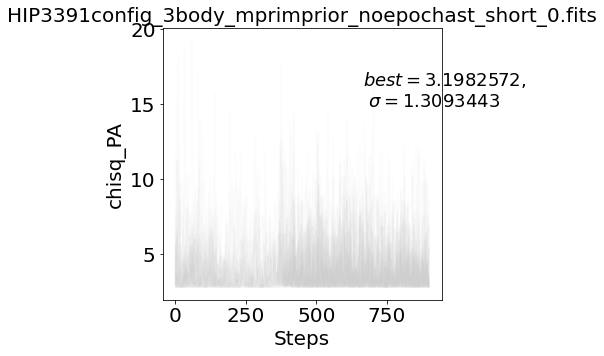

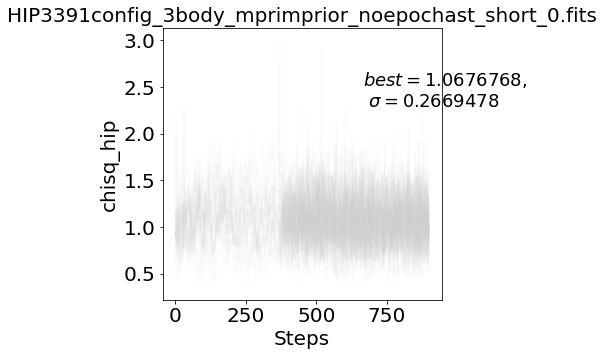

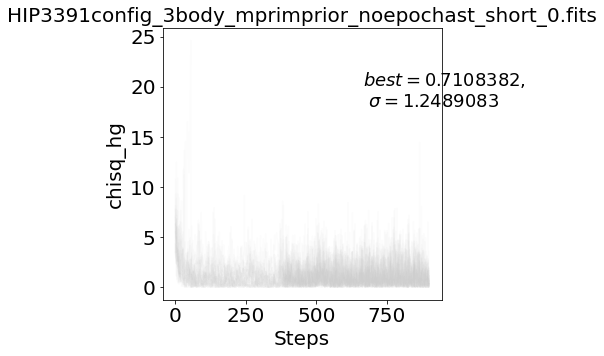

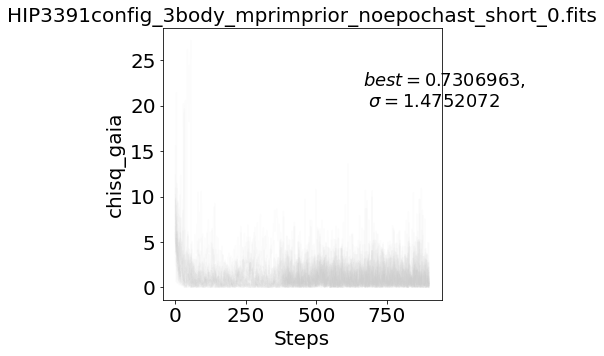

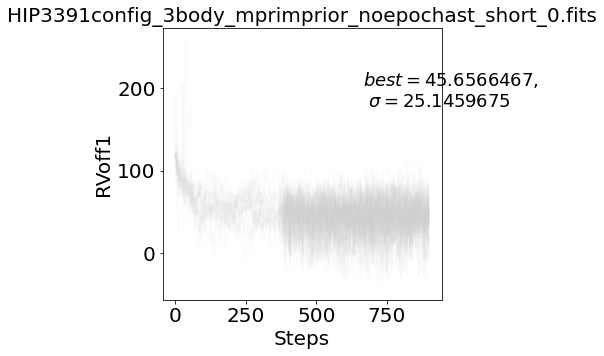

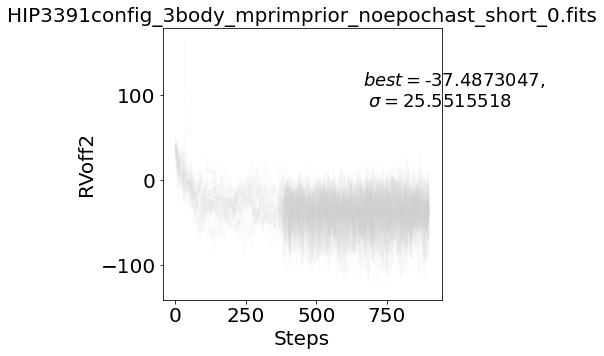

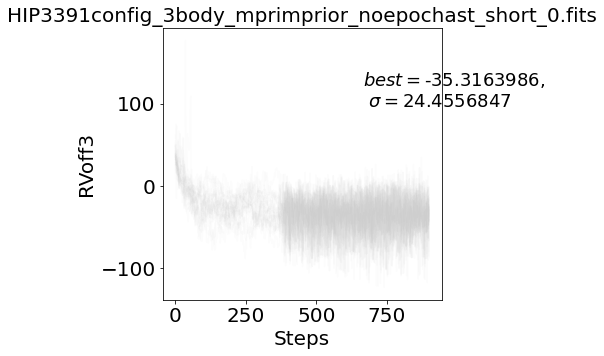

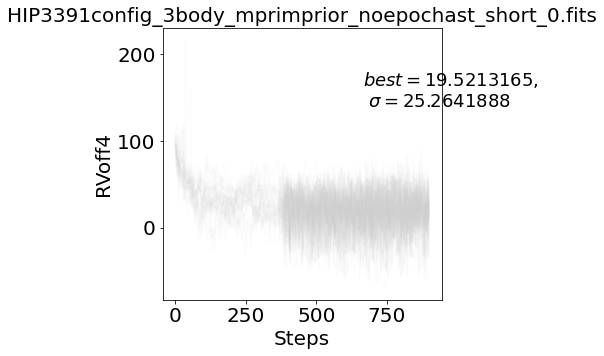

In [17]:
chisqchain = fits.open(path)[-1].data
logl = fits.open(path)[1].data
print(logl[logl == np.max(logl)])
chisquareds = chisqchain[np.amax(logl)==logl][0]
nRV_instruments =  chisqchain.shape[-1] - 8
print(f'{nRV_instruments} RV instruments with {nRV_instruments} offsets')
for i, lbl in zip(chisquareds, ['best fit parallax (as)', 'pm_ra_barycenter (as/yr)', 
                              'pm_dec_barycenter (as/yr)', 'chisq_sep', 'chisq_PA', 'chisq_hip', 'chisq_hg', 'chisq_gaia']):
    print(lbl, ' = ', i)

for idx, mp, lbl in zip(list(np.arange(8)) + list(np.arange(-nRV_instruments, 0)), [1000, 1000, 1000, 1, 1, 1, 1, 1] + [1]*nRV_instruments, ['best fit parallax (mas)', 'pm_ra_barycenter (mas/yr)', 
                              'pm_dec_barycenter (mas/yr)', 'chisq_sep', 'chisq_PA', 'chisq_hip', 'chisq_hg', 'chisq_gaia'] + 
                        ['RVoff' + str(i) for i in range(1, nRV_instruments+1)]):
    plt.figure(figsize=(5,5))
    for i in range(chisqchain.shape[0]//5):
        plt.plot(chisqchain[i, 100:, idx]*mp, c='grey', alpha=0.02)
    plt.title(source,fontsize=20)
    plt.xlabel('Steps',fontsize=20)
    plt.ylabel(lbl,fontsize=20)
    plt.annotate(s=fr'$best=${np.median(chisqchain[i, burn:, idx])*mp:.7f},' + '\n ' + fr'$\sigma=${np.std(chisqchain[i, burn:, idx])*mp:.7f}', 
                 xy=(0.6, 0.7), xycoords='figure fraction', fontsize=18)
    print(lbl, idx)
    print(fr'{np.median(chisqchain[i, burn:, idx])*mp:.7f} \pm {np.std(chisqchain[i, burn:, idx])*mp:.7f}')

plt.show()